In [1]:
%load_ext autoreload
%autoreload
import warnings; warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
# Python dependences
import os, time
import numpy as np   # Numpy - Python's numerical library
import matplotlib.pyplot as plt  # Matplotlib - Python's plotting library
from copy import deepcopy   # Python module for copying objects

# Input and Output Tools
# Catalogue and sources 
from openquake.hmtk.parsers.catalogue import CsvCatalogueParser   # Reads an earthquake catalogue from CSV
from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter  # Writes an earthquake catalogue to CSV
from openquake.hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser  # Imports a source model from XML

# Completeness tools
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971

# Plotting tools
from openquake.hmtk.plotting.seismicity.completeness import plot_stepp_1972
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from openquake.hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_recurrence_model
from openquake.hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                      get_completeness_adjusted_table,
                                                      _get_catalogue_bin_limits)

# Recurrence and Mmax
from openquake.hmtk.seismicity.occurrence.kijko_smit import KijkoSmit
from openquake.hmtk.seismicity.occurrence.weichert import Weichert
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
from openquake.hmtk.seismicity.max_magnitude.kijko_nonparametric_gaussian import KijkoNonParametricGaussian
from openquake.hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment
from openquake.hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment

# Catalogue selector - we will see this in action
from openquake.hmtk.seismicity.selector import CatalogueSelector

from openquake.hazardlib.mfd import TruncatedGRMFD

In [3]:
catalogue_file = "input_data/Overall_Seismicity_Dec_Shallow 2021.03.23.csv"
parser = CsvCatalogueParser(catalogue_file)
catalogue = parser.read_file(start_year=1900)

# Load in a Source Model File

In [4]:
source_model_file = "input_data/AreaSource_Shallow.xml"
#source_model_file = "input_data/AreaSource_MidCrust.xml"
#source_model_file = "input_data/AreaSource_Deep.xml"
parser = nrmlSourceModelParser(source_model_file)

# Parse the seismic sources and save them into a variable called "source_model"
source_model = parser.read_file("AreaSource_Shallow") # You need to supply a name for the source model

In [5]:
llon, ulon, llat, ulat = catalogue.get_bounding_box()
map_config = {'min_lon': np.floor(llon), 'max_lon': np.ceil(ulon),
              'min_lat': np.floor(llat), 'max_lat': np.ceil(ulat), 'resolution':'i'}

# basemap1 = HMTKBaseMap(map_config, 'Earthquake Catalogue + Area Sources')
# Adding the catalogue to the basemap
# basemap1.add_catalogue(catalogue, overlay=True)
# Adding the seismic sources
# basemap1.add_source_model(source_model, area_border='r-', border_width=1.5, alpha=0.5) 

### A Source Model Workflow - Area Source Example

Each of the area sources has:

1. Defined name, ID, tectonic region type

2. Geometry (polygon)

3. Magnitude Scaling Relation (Wells & Coppersmith, 1994)

4. Rupture Aspect Ratio (1.5)

5. Nodal Plane Distribution (varies)


But they are missing the magnitude frequency distribution and the hypocentral depth distribution!

Using the observed catalogue - define the MFD as a Truncated Gutenberg-Richer model for each source

Assume $M_{MIN} = 4.8$

### Completeness of Sub-Catalog

Completeness: ok


Completeness table using Stepp method (1971)
[[2006.     4.7]
 [1999.     4.8]
 [1985.     4.9]
 [1978.     5. ]
 [1978.     5.1]
 [1961.     5.2]
 [1961.     5.3]
 [1961.     5.4]
 [1961.     5.5]
 [1961.     5.6]
 [1961.     5.7]
 [1956.     5.8]
 [1940.     5.9]
 [1940.     6. ]
 [1940.     6.1]
 [1905.     6.2]
 [1905.     6.3]
 [1905.     6.4]
 [1905.     6.5]
 [1905.     6.6]
 [1905.     6.7]
 [1905.     6.8]
 [1905.     6.9]
 [1905.     7. ]
 [1905.     7.1]
 [1905.     7.2]
 [1905.     7.3]
 [1905.     7.4]
 [1905.     7.5]
 [1905.     7.6]
 [1905.     7.7]
 [1905.     7.8]
 [1905.     7.9]
 [1905.     8. ]
 [1905.     8.1]
 [1905.     8.2]
 [1905.     8.3]]




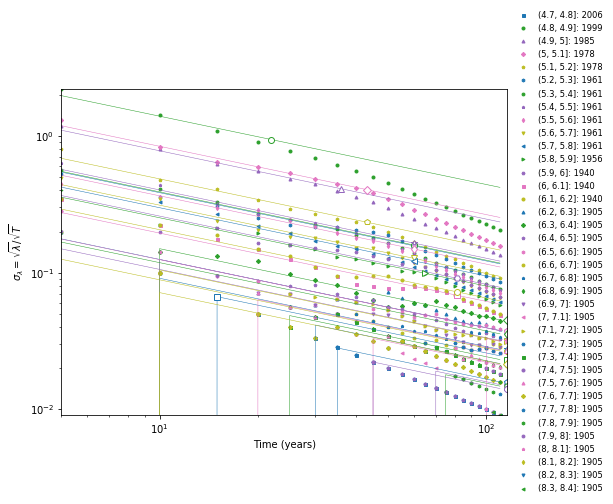

In [6]:
# Set up the configuration parameters
comp_config = {'magnitude_bin': 0.1, 'time_bin': 5.0, 'increment_lock': True}

# Calling the method by Stepp (1971)
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(catalogue, comp_config)
print('Completeness: ok')

# Print the completeness table
print('\n')
print('Completeness table using Stepp method (1971)')
print(completeness_table)
print('\n')

# Setting configuration for the completeness plot
completeness_parameters = completeness_algorithm
output_file = "output_data/Shallow_Completeness_Overall_Plot.png"
if os.path.exists(output_file):
    os.remove(output_file)

plot_stepp_1972.create_stepp_plot(completeness_parameters, figure_size=(8, 6), 
                                  filename=output_file, filetype='png', dpi=300, ax=None)

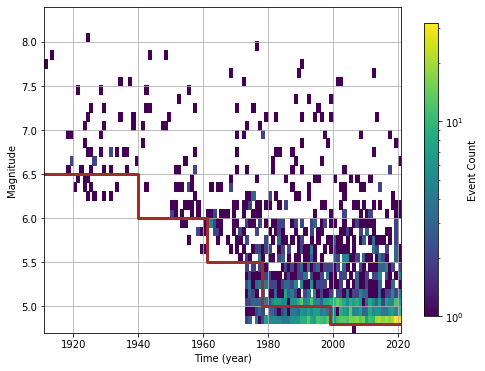

In [7]:
completeness_table = np.array([[1999.,     4.8],
                                 [1978.,     5. ],
                                 [1961.,     5.5],
                                 [1940.,     6. ],
                                 [1905.,     6.5],
                                 [1905.,     7. ],
                                 [1905.,     7.5],
                                 [1905.,     8. ],
                                 [1905.,     8.3]]
                             )

plot_magnitude_time_density(catalogue, 0.1, 1.0,
                            completeness=completeness_table)

min_mag = 4.8

selector1 = CatalogueSelector(catalogue, create_copy=True)

In the following workflow we will, for each source:

1. Select the earthquakes within the source

2. Plot them on a map

3. Use them to calculate a- and b-value from the Weichert (1980) method

4. Estimate Mmax using the cumulative moment method (plus a small offset)

5. View the hypocentral depth distribution - and use the density to define the hypocentral depth distribution for the source

----------------------------------------------------------------------------
Source ID: 1  Source Name: Shallow PT   Number of Events: 265
a = 6.571 (+/- 0.028),  b = 1.212 (+/-0.067)
Mmax (Observed) = 7.60 Mmax (Inferred) = 8.014 +/- nan
Upper Seismogenic Depth: 0.00, Lower Seismogenic Depth: 50.00
----------------------------------------------------------------------------
Source ID: 2  Source Name: Shallow ELT   Number of Events: 29
a = 6.402 (+/- 0.078),  b = 1.365 (+/-0.226)
Mmax (Observed) = 6.90 Mmax (Inferred) = 7.835 +/- nan
Upper Seismogenic Depth: 0.00, Lower Seismogenic Depth: 50.00
----------------------------------------------------------------------------
Source ID: 3  Source Name: Shallow NT   Number of Events: 22
a = 3.406 (+/- 0.103),  b = 0.809 (+/-0.296)
Mmax (Observed) = 6.30 Mmax (Inferred) = 6.626 +/- nan
Upper Seismogenic Depth: 0.00, Lower Seismogenic Depth: 50.00
----------------------------------------------------------------------------
Source ID: 4  Source 

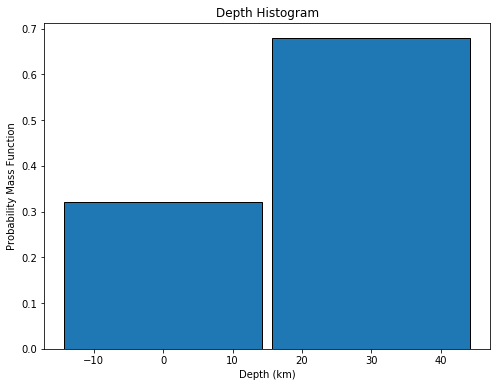

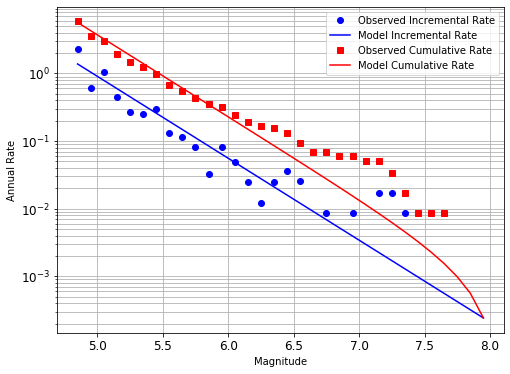

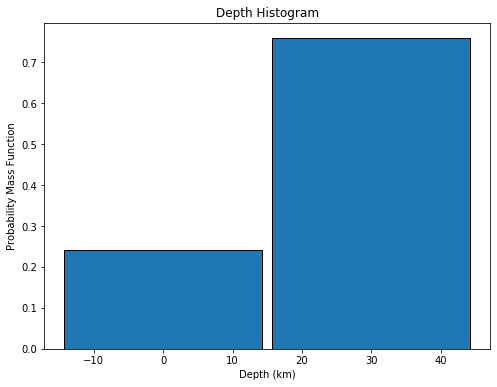

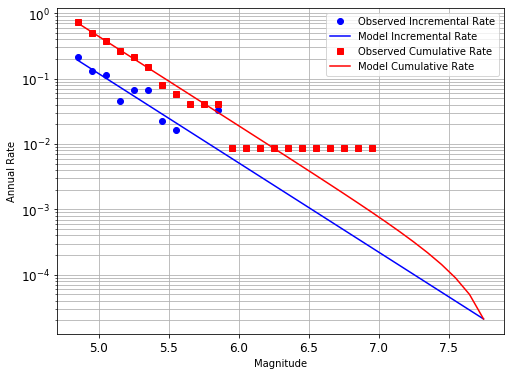

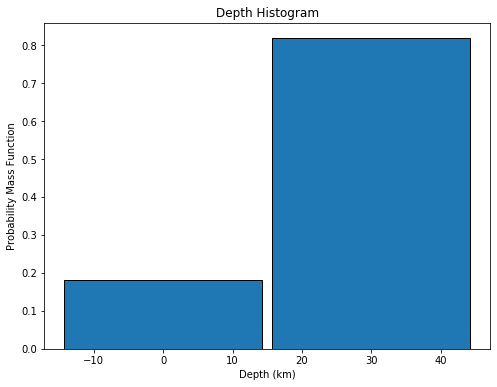

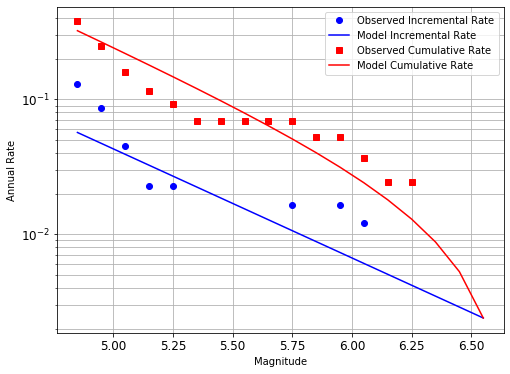

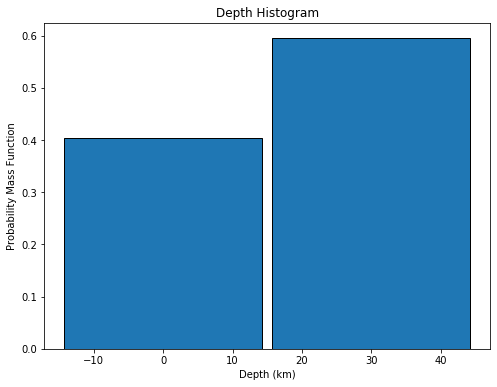

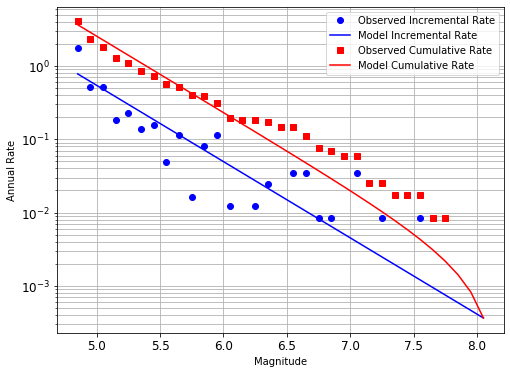

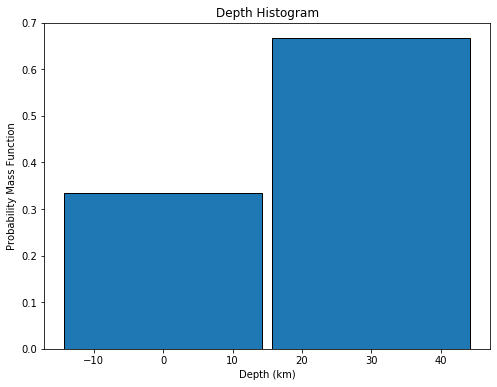

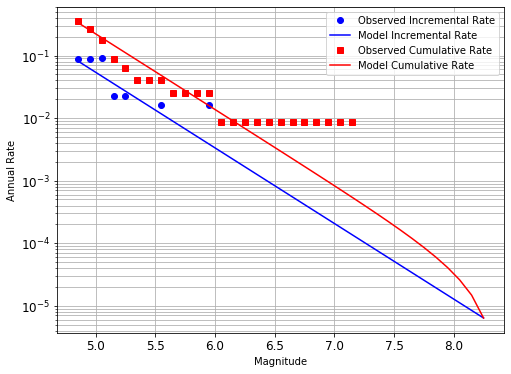

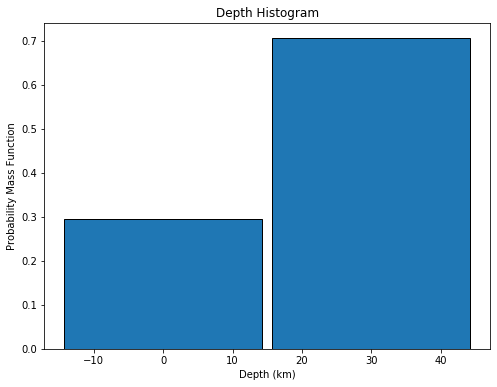

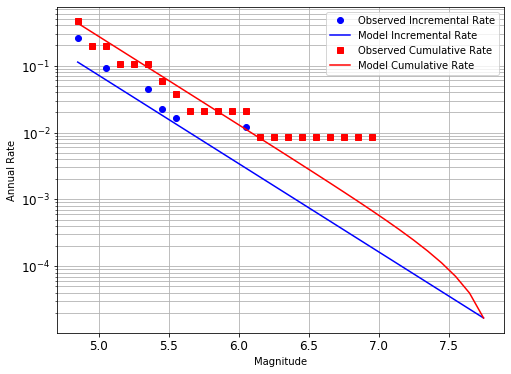

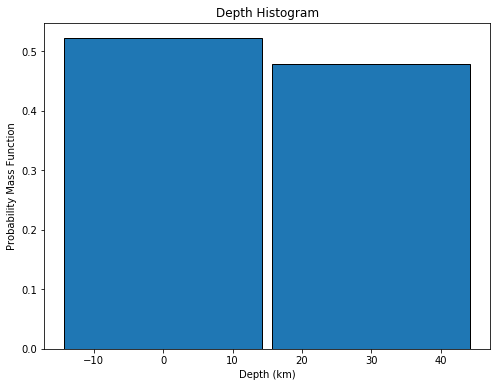

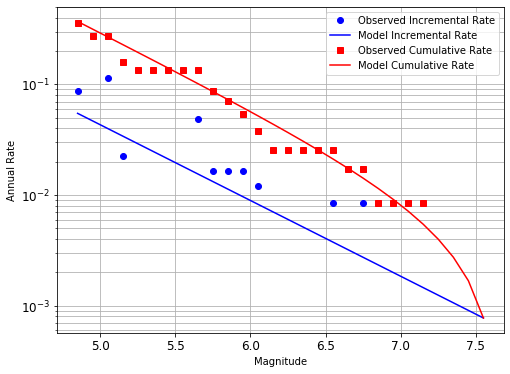

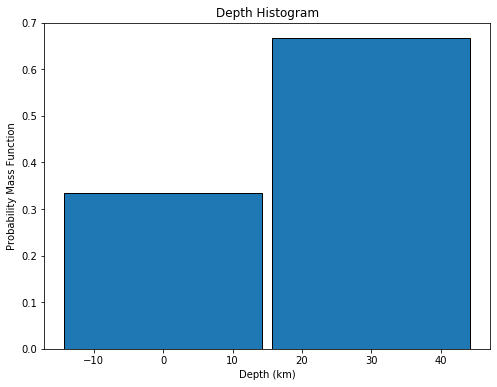

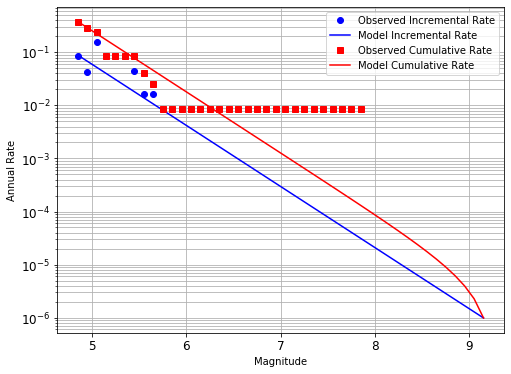

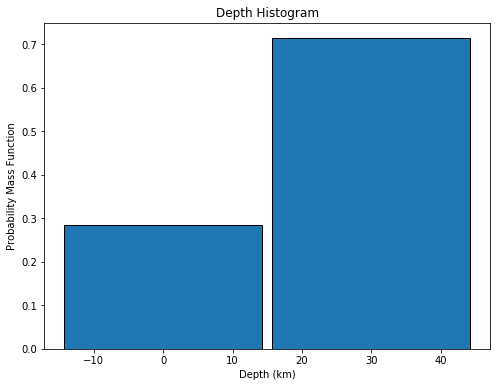

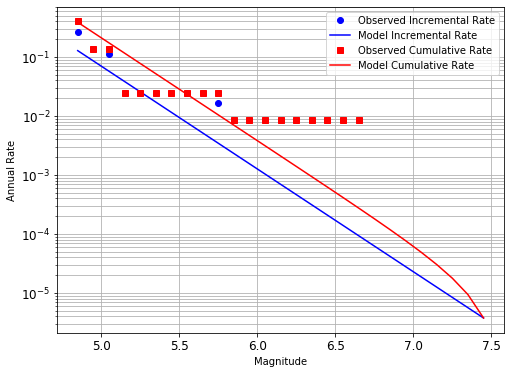

In [8]:
IdList = ['1', '2','3','4','6','7','8','9','10'] #Shallow
#IdList = ['12','13A','13B'] #MidCrust
#IdList = ['15A','15B'] #Deep

for source in source_model.sources:

    print ('----------------------------------------------------------------------------')
    # Select the earthquakes within the source
    source.select_catalogue(selector1)
    print("Source ID: %s  Source Name: %s   Number of Events: %g" % (source.id, source.name,
                                                                     source.catalogue.get_number_events()))

    # Get the a- and b-value using Weichert (1980)
    occurrence = Weichert()
    recurrence_config = {"magnitude_interval": 0.1}
    bval, sigma_b, aval, sigma_a = occurrence.calculate(source.catalogue,
                                                        recurrence_config,
                                                        completeness_table)
    print("a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b))


    # Estimate the Maximum Magnitude - using the Cumulative Moment method
    # mmax_config = {"number_bootstraps": 100}
    # mmax_calculator = CumulativeMoment()
    # mmax, sigma_mmax = mmax_calculator.get_mmax(source.catalogue, mmax_config)
    # print("Mmax (Observed) = %.2f Mmax (Inferred) = %.3f +/- %.3f" % (
    #    np.max(source.catalogue.data["magnitude"]), mmax + 0.2, sigma_mmax))
    
    # Estimate the Maximum Magnitude - using the Kijko & Smit Nonparametric Gaussian
    mmax_config = {"input_mmin": 4.8, 
                   "input_mmax": None, 
                   "input_uncertainty": None,
                   "b-value": bval,
                   "sigma-b": sigma_b,
                   "number_earthquakes": 5,
                  }
    
    #mmax_config = {
    #              "number_bootstraps": 1000
    #              }
    mmax_calculator = KijkoNonParametricGaussian()
    #mmax_calculator = CumulativeMoment()
    mmax, sigma_mmax = mmax_calculator.get_mmax(source.catalogue, mmax_config)
    print("Mmax (Observed) = %.2f Mmax (Inferred) = %.3f +/- %.3f" % (
        np.max(source.catalogue.data["magnitude"]), mmax + 0.2, sigma_mmax))
    
    
    
    # Compare the model against data
    source.mfd = TruncatedGRMFD(min_mag, mmax + 0.2, 0.1, aval, bval)

    if source.id in IdList:
        # Map the Source
        #src_basemap = HMTKBaseMap(map_config, "Source: {:s}".format(source.name))
        # Add on the catalogue
        #src_basemap.add_catalogue(source.catalogue)

        # Show the depth histogram
        depth_interval = 30.0  # in km
        # 50-70 deep; 30 otherwise
        
        
        plot_depth_histogram(source.catalogue, depth_interval, normalisation=True)
        plot_recurrence_model(source.mfd, source.catalogue, completeness_table, 0.1)
    
        # Add the probability mass function of the hypocentre depths to the source
        depth_bins = np.arange(source.upper_depth,
                               source.lower_depth + depth_interval,
                               depth_interval)
        source.hypo_depth_dist = source.catalogue.get_depth_pmf(depth_bins)
        # Wait for the plotting to catch up!
        
        print("Upper Seismogenic Depth: %.2f, Lower Seismogenic Depth: %.2f" %(source.upper_depth, source.lower_depth))

    time.sleep(1.0)

In [9]:
source_model.serialise_to_nrml("output_data/AreaSource_Shallow.xml")
#source_model.serialise_to_nrml("output_data/AreaSource_MidCrust.xml")
#source_model.serialise_to_nrml("output_data/AreaSource_Deep.xml")

### Exploring Fault Sources in the Gulf of Corinth

In [ ]:
fault_model_file = "input_data/source_models/GulfOfCorinth_minimal.xml"
parser = nrmlSourceModelParser(fault_model_file)
fault_sources = parser.read_file("Gulf of Corinth Faults")

#### Visualise

In [ ]:
map_config = {'min_lon': 20.9, 'max_lon': 24.0,
              'min_lat': 37.5, 'max_lat': 39.0, 'resolution':'h'}

# Map the Source
src_basemap = HMTKBaseMap(map_config, "Gulf of Corinth Faults & Seismicity")
# Add on the catalogue
src_basemap.add_catalogue(catalogue, overlay=True)
src_basemap.add_source_model(fault_sources)